# Gerador de músicas de forro

O intuito desse projeto, é utilizar uma Rede Neural Recorrente (RNN), mas precisamente LSTM, para geração de letras de forró, ou tentativas.

Para tal processo, foi coletado dados, de 9 artistas diferentes, do gênero de Forró, sendo cerca de 2420 músicas coletadas e um corpus de 1750955.


## Scraper
Para coleta dos dados, foi utilizado as Bibliotecas BeautifulSoup e os dados foram coletados no vagalume, site que agrega músicas de diversos artistas.

In [531]:
def get_scraper(url,filename):
  page_lista = requests.get(url)
  soup_lista = BeautifulSoup(page_lista.content, 'html.parser')
  soup_ol = soup_lista.find("ol", id="alfabetMusicList")


  ### Loop extrair os links e salvar dentro de uma lista
  url_lista = []
  
  for link in soup_ol:
  
    for div in link.find_all("a", class_="nameMusic"):
        link_novo = "https://www.vagalume.com.br" + div.get('href') 
        url_lista.append(link_novo)
    print(url_lista)
  file = open(filename, 'w', encoding='utf8', newline='')
  writer = csv.writer(file, delimiter=',')
  writer.writerow(['Titulo', 'Artista', 'Album', 'Ano', 'Letra'])

  ### Loop para raspar todas as páginas da lista

  counter = 0

  for link in url_lista:
      ### Para acompanhar progresso
      counter = counter + 1 
      print("\n")
      print("### Raspando letra " + str(counter) + " Link: " + str(link))
      
      ### Raspa html de cada elemento da lista url_lista
      page = requests.get(link)
      soup = BeautifulSoup(page.content, 'html.parser')
      page

      ### Rapsar título
      titulo_html = soup.select('div h1')[1]
      titulo = titulo_html.text

      ### Raspar Artista
      artista_html = soup.select('div h2')[0]
      artista = artista_html.text
      letra_html = soup.select('div#lyrics')
      ### Tira elementos html e transforma sopa em strig
      t = str(letra_html)
      letra_suja = str(re.sub("<.*?>", " ", t))
      ### Substitui caracteres indesejados
      letra_suja = letra_suja.replace('[', '')
      letra_suja = letra_suja.replace(']', '')
      letra_suja = letra_suja.replace('  ', ' ')
      letra = letra_suja.strip()
      rowData = [titulo, artista,  letra]
      writer.writerow(rowData)
      print(rowData) 
      
  file.close()

In [ ]:
artistas = ['calcinha-preta']
for art in artistas:
  url_lista = f"https://www.vagalume.com.br/{art}/"
  file_name = f"letras_{art}.csv"
  print(f"Scraper de {art} ")
  get_scraper(url_lista, file_name)
  print("Finalizando Coleta de Musicas")

In [502]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Construção do Modelo

In [503]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import layers, Model
import os
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,GRU
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [504]:
import unidecode

In [505]:
df = pd.read_csv("letras_forro.csv")

In [506]:
batch_size = 64
rnn_neurons = 1026

In [507]:
text = ''
for letra in df['Album'].unique():
  aux_text = letra.lower()
  text += aux_text

In [508]:
chars = sorted(list(set(text)))
print(f"Palavras Distintas: {len(chars)}")

Palavras Distintas: 94


In [509]:
max_len = 20 # É evidar redudância
step = 3
input_chars = []
output_chars = []

In [510]:
for i in range(0, len(text) - max_len, step):
    input_chars.append(text[i : i + max_len])
    output_chars.append(text[i + max_len])

In [511]:
print("Número de Sequências:", len(input_chars))
print("Palavra entrada  (input_chars)  --->   Saída (next_char) ")

for i in range(5):
  print(f"Palavra Completa {input_chars[i] + output_chars[i]}")
  print( f"Entrada {input_chars[i]} -> {output_chars[i]}")
  print()


Número de Sequências: 583645
Palavra entrada  (input_chars)  --->   Saída (next_char) 
Palavra Completa a casa que vovô morou
Entrada a casa que vovô moro -> u

Palavra Completa asa que vovô morou o 
Entrada asa que vovô morou o ->  

Palavra Completa  que vovô morou o meu
Entrada  que vovô morou o me -> u

Palavra Completa e vovô morou o meu pa
Entrada e vovô morou o meu p -> a

Palavra Completa ovô morou o meu pai h
Entrada ovô morou o meu pai  -> h



In [512]:
# Criação deu m conjunto de dados de treinamento
X_train_ds_raw=tf.data.Dataset.from_tensor_slices(input_chars)
y_train_ds_raw=tf.data.Dataset.from_tensor_slices(output_chars)

In [513]:
def normalize(input_data):
    lowercase     = tf.strings.lower(input_data) #deixa palavras lower_case
    stripped_num  = tf.strings.regex_replace(lowercase, "[\d-]", " ") #remove numeros
    stripped_punc =tf.strings.regex_replace(stripped_num, "[%s]" % re.escape(string.punctuation), "")   #remove pontuacao 
    return stripped_punc

def char_split(input_data):
  return tf.strings.unicode_split(input_data, 'UTF-8') #split de cada palavra em unicode


In [514]:
# Model constants.
max_features = 96           # Numero depalavras distntas
embedding_dim = 10             # Embedding layer output dimension
sequence_length = max_len 

In [515]:
vectorize_layer = TextVectorization(
    standardize=normalize,
    max_tokens=max_features,
    split=char_split, 
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [516]:
vectorize_layer.adapt(X_train_ds_raw.batch(batch_size))

In [517]:
print("Tamanho do Vocabulario: ", len(vectorize_layer.get_vocabulary()))

Tamanho do Vocabulario:  60


In [518]:
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

In [519]:

X_train_ds = X_train_ds_raw.map(vectorize_text)
y_train_ds = y_train_ds_raw.map(vectorize_text)

X_train_ds.element_spec, y_train_ds.element_spec

(TensorSpec(shape=(20,), dtype=tf.int64, name=None),
 TensorSpec(shape=(20,), dtype=tf.int64, name=None))

In [520]:
y_train_ds=y_train_ds.map(lambda x: x[0])

In [521]:
train_ds =  tf.data.Dataset.zip((X_train_ds,y_train_ds))


In [522]:
def decode_sequence (encoded_sequence):
  deceoded_sequence=[]
  for token in encoded_sequence:
    deceoded_sequence.append(vectorize_layer.get_vocabulary()[token])
  sequence= ''.join(deceoded_sequence)
  return sequence

In [523]:
AUTOTUNE = tf.data.AUTOTUNE #reduz o tempo de processamento
train_ds = train_ds.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

# Sampling

Na geração de texto, a técnica de sampling, é utilizada para escolher o próximo token de acordo com a probabilidade.

Ou seja, dada um conjunto de tokens, para cada entrada é necessário selecionar o próximo token de acordo com a distribuição.
* **Greedy Search**:
Seleciona a partir de uma palavra a próxima, cujo a mesma tenha uma alta probabilidade,
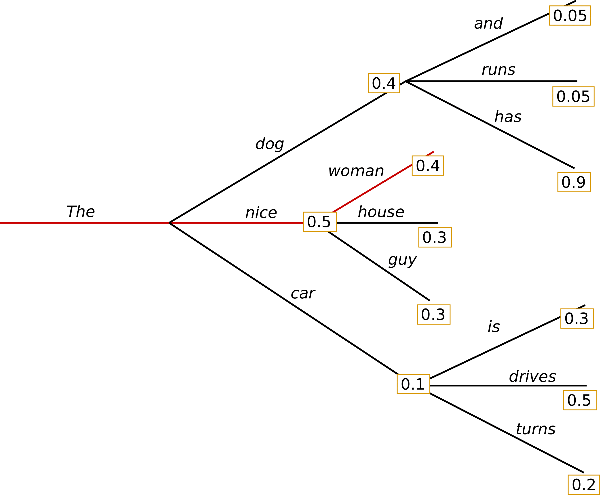

* **Temperature Sampling**:
Inspirada na termodinamica, onde alta temperatura significa que estados de baixa energia são mais prováveis ​​de serem encontrados. Nos modelos de probabilidade, os logits desempenham o papel de energia e podemos implementar a amostragem de temperatura dividindo os logits pela temperatura antes de alimentá-los no softmax e obter nossas probabilidades de amostragem.
Temperaturas mais baixas tornam o modelo cada vez mais confiante em suas principais escolhas, enquanto temperaturas maiores que 1 diminuem a confiança. A temperatura 0 é equivalente à probabilidade argmax/max, enquanto a temperatura infinita corresponde a uma amostragem uniforme.

* **Top K Sampling**:
Amostragem top k significa classificar por probabilidade e zerar as probabilidades para qualquer coisa abaixo do k'th token. Na amostragem Top-K, as K próximas palavras mais prováveis ​​são filtradas e a massa de probabilidade é redistribuída apenas entre as K próximas palavras. Parece melhorar a qualidade removendo a cauda e tornando menos provável que saia do tópico. Mas, em alguns casos, realmente há muitas palavras das quais podemos amostrar razoavelmente (distribuição ampla abaixo), e em alguns casos não há (distribuição restrita abaixo).

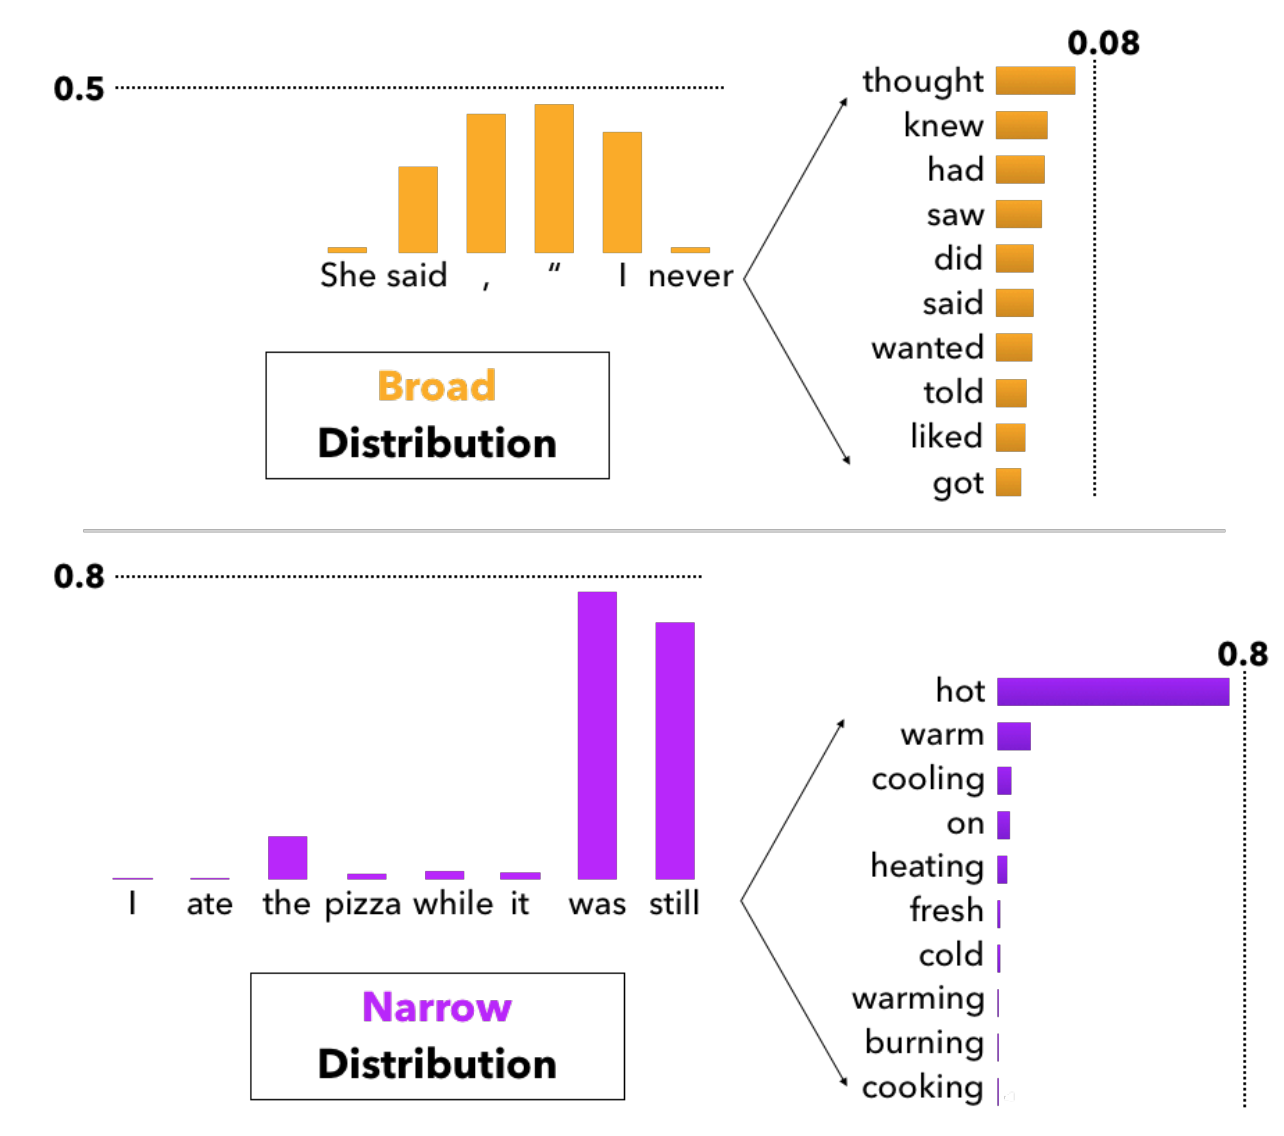

In [524]:
def softmax(z):
  return np.exp(z)/sum(np.exp(z))

def greedy_search(conditional_probability):
  return (np.argmax(conditional_probability))

def temperature_sampling (conditional_probability, temperature=1.0):
  conditional_probability = np.asarray(conditional_probability).astype("float64")
  conditional_probability = np.log(conditional_probability) / temperature
  reweighted_conditional_probability = softmax(conditional_probability)
  probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
  return np.argmax(probas)

def top_k_sampling(conditional_probability, k):
  top_k_probabilities, top_k_index= tf.math.top_k(conditional_probability, k=k, sorted=True)
  top_k_probabilities= np.asarray(top_k_probabilities).astype("float32")
  top_k_probabilities= np.squeeze(top_k_probabilities)
  top_k_index = np.asarray(top_k_index).astype("int32")
  top_k_redistributed_probability = softmax(top_k_probabilities)
  top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
  sampled_token = np.random.choice(np.squeeze(top_k_index), p=top_k_redistributed_probability)
  return sampled_token


# Modelo 
Para o processo de criação de novas "músicas de forró", foi utilizado a arquitetura LSTM.

LSTM é uma Rede Neural Recorrente (RNN), que lembra de valores arbitrários 
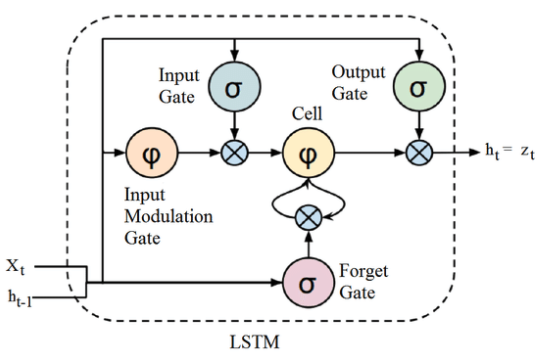

Forget Gate: As informações que não são mais úteis no estado da célula são removidas com o forget gate. Duas entradas: x_t (entrada no momento específico) e h_t-1 (saída de célula anterior) são alimentadas ao gate e multiplicadas por matrizes de peso, seguidas pela adição do bias. O resultante é passado por uma função de ativação que fornece uma saída binária. Se para um determinado estado de célula a saída for 0, a informação é esquecida e para a saída 1, a informação é retida para uso futuro.

Input Gate: A adição de informações úteis ao estado da célula é feita pelo input gate. Primeiro, a informação é regulada usando a função sigmoide que filtra os valores a serem lembrados de forma similar ao forget gate usando as entradas h_t-1 e x_t. Então, um vetor é criado usando a função tanh que dá saída de -1 a +1, que contém todos os valores possíveis de h_t-1 e x_t. Os valores do vetor e os valores regulados são multiplicados para obter as informações úteis

Output Gate: A tarefa de extrair informações úteis do estado da célula atual para ser apresentadas como uma saída é feita pelo output gate. Primeiro, um vetor é gerado aplicando a função tanh na célula. Então, a informação é regulada usando a função sigmóide que filtra os valores a serem lembrados usando as entradas h_t-1 e x_t. Os valores do vetor e os valores regulados são multiplicados para serem enviados como uma saída e entrada para a próxima célula.


Para o nosso problema, de geração de Texto por caractere, cada input de texto, de acordo com as técnicas de sampling, de maior probabilidade de uma novo caracterer aparecer, é computado no modelo, e esse output é utilizado para prever as próximas palavras.

In [525]:
from tensorflow.keras.layers import Flatten
def create_model(sequence_length: int, max_features:int, embedding_dim:int, rnn_neurons:int,batch_size:int):
  inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")
  x = layers.Embedding(max_features, embedding_dim)(inputs) #Num de palavras distintas
  x = layers.Dropout(0.5)(x) #Camada de Dropout, evitar overfitting
  x = layers.LSTM(rnn_neurons, return_sequences=True)(x) 
  x = layers.Flatten()(x) #LSTM RNN_NEUROS = 1026, return_sequences, ele da output da palavra
  predictions=  layers.Dense(max_features, activation='softmax')(x)
  model= tf.keras.Model(inputs, predictions)
  print(model.summary())
  model.compile(loss='sparse_categorical_crossentropy', 
                   optimizer='adam', metrics=['accuracy'])
  return model

In [526]:
model = create_model(sequence_length, max_features, embedding_dim, rnn_neurons, batch_size)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 20)]              0         
                                                                 
 embedding_37 (Embedding)    (None, 20, 10)            960       
                                                                 
 dropout_27 (Dropout)        (None, 20, 10)            0         
                                                                 
 lstm_22 (LSTM)              (None, 20, 1026)          4255848   
                                                                 
 flatten_10 (Flatten)        (None, 20520)             0         
                                                                 
 dense_29 (Dense)            (None, 96)                1970016   
                                                                 
Total params: 6,226,824
Trainable params: 6,226,824
Non-tr

In [528]:
history = model.fit(train_ds, epochs=20) 

Epoch 1/20
9119/9119 [==============================] - 118s 13ms/step - loss: 1.6531 - accuracy: 0.5009
Epoch 2/20
9119/9119 [==============================] - 117s 13ms/step - loss: 1.5774 - accuracy: 0.5219
Epoch 3/20
9119/9119 [==============================] - 119s 13ms/step - loss: 1.5177 - accuracy: 0.5382
Epoch 4/20
9119/9119 [==============================] - 120s 13ms/step - loss: 1.4650 - accuracy: 0.5520
Epoch 5/20
9119/9119 [==============================] - 118s 13ms/step - loss: 1.4199 - accuracy: 0.5649
Epoch 6/20
9119/9119 [==============================] - 119s 13ms/step - loss: 1.3784 - accuracy: 0.5759
Epoch 7/20
9119/9119 [==============================] - 118s 13ms/step - loss: 1.3414 - accuracy: 0.5863
Epoch 8/20
9119/9119 [==============================] - 118s 13ms/step - loss: 1.3055 - accuracy: 0.5962
Epoch 9/20
9119/9119 [==============================] - 118s 13ms/step - loss: 1.2726 - accuracy: 0.6053
Epoch 10/20
9119/9119 [==============================] 

In [529]:
import matplotlib.pyplot as plt

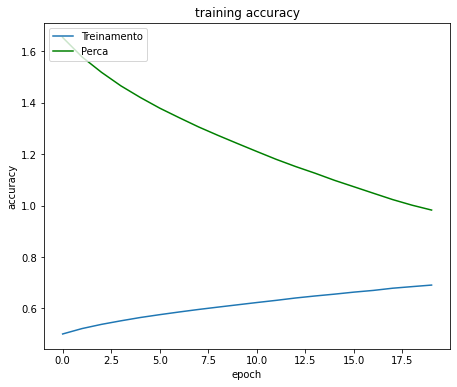

In [530]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'], color='green')
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.legend(['Treinamento', 'Perca'], loc='upper left')
plt.xlabel('epoch')
plt.show()

In [532]:
def decode_sequence (encoded_sequence):
  deceoded_sequence = []
  for token in encoded_sequence:
    deceoded_sequence.append(vectorize_layer.get_vocabulary()[token])
  sequence= ''.join(deceoded_sequence)
  print("\t",sequence)
  return sequence


In [533]:
def generate_text(model, seed_original, step):
    seed= vectorize_text(seed_original)
    print(f"A palavra foi {seed_original}")
    decode_sequence(seed.numpy().squeeze())
    

    seed= vectorize_text(seed_original).numpy().reshape(1,-1)
   
    generated_greedy_search = (seed)
    for i in range(step):
      predictions=model.predict(seed)
      next_index= greedy_search(predictions.squeeze())
      generated_greedy_search = np.append(generated_greedy_search, next_index)
      seed= generated_greedy_search[-sequence_length:].reshape(1,sequence_length)
    print("Texto gerado pelo Greedy: ")
    decode_sequence(generated_greedy_search)

    print("Texto gerado pelo Temperature")
    for temperature in [0.2, 0.5, 0.7, 0.9, 1, 1.2]:
        print("\ttemperature: ", temperature)
        seed= vectorize_text(seed_original).numpy().reshape(1,-1)
        generated_temperature = (seed)
        for i in range(step):
            predictions=model.predict(seed)
            next_index = temperature_sampling(predictions.squeeze(), temperature)
            generated_temperature = np.append(generated_temperature, next_index)
            seed= generated_temperature[-sequence_length:].reshape(1,sequence_length)
        decode_sequence(generated_temperature)

    print("Texto gerado pelo Top K:")
    for k in [2, 3, 4, 5]:
        print("\tTop-k: ", k)
        seed= vectorize_text(seed_original).numpy().reshape(1,-1)
        generated_top_k = (seed)
        for i in range(step):
            predictions=model.predict(seed)
            next_index = top_k_sampling(predictions.squeeze(), k)
            generated_top_k = np.append(generated_top_k, next_index)
            seed= generated_top_k[-sequence_length:].reshape(1,sequence_length)
        decode_sequence(generated_top_k)


In [534]:
generate_text(model,"amo meu sertão", 250)

A palavra foi amo meu sertão
	 amo meu sertão
Texto gerado pelo Greedy: 
	 amo meu sertão eu vou tocando e gança veja só pensa em te amar eu te amo e que você me fiz sentido te amar eu tô lembro de você ela vai mais casreiros e a minha vida e você que me faz viver er não consigo entender que ele vai na cortar salta que eu sei que você me
Texto gerado pelo Temperature
	temperature:  0.2
	 amo meu sertão ela me diz o que eu vou fazer você me leva ao seu lado eu te amo demais na mão eu vou viver essa suluuãão me acostumei a ligação que agente se amar e a fazerda nesse solidão me diz o que eu vou fazer você me leva ao seu lado te amo mais novamos assi
	temperature:  0.5
	 amo meu sertão eu vou te encontrarrale você tentando me invadiu o meu coração te amar você me leva mais amor pra sempre e hoje eu vio agora como é demais pelo meu amor peixe a cartilha pareada pela tudo que eu quero e vou brincar com você meu bem não tem gest
	temperature:  0.7
	 amo meu sertão e o cono eu vou beijar você

In [535]:
generate_text(model,"me liga essa noite", 250)

A palavra foi me liga essa noite
	 me liga essa noite
Texto gerado pelo Greedy: 
	 me liga essa noite vem meu amor eu vou viver essa selidão eu não volto atrás você você você me lembrar de mim te amo demais na mão eu vou viver essa selidão eu não volto atrás você você você me lembrar de mim te amo demais na mão eu vou viver essa selidão eu não volt
Texto gerado pelo Temperature
	temperature:  0.2
	 me liga essa noite vem meu amor eu já te esqueci tô com a vida de conta de mim se você me enganava tá querendo se você quiser voltar me enganar bem gostoso eu já te espero nenando essa paixão que você me falava que eu te amo e que você te ligando você me diz pra voc
	temperature:  0.5
	 me liga essa noite vem pra pançar tudo não pas meu novem cama fora do meu peito um gesmo de vez perdeu a gente te ver foi iculão e minha vida é você pra mim fala pois qui meu beijo ela nem te amar pois as nasteldes pensar que é por amor chegou ao fim ja sofrendo s
	temperature:  0.7
	 me liga essa noite vem l

In [536]:
generate_text(model,"são joão", 250)

A palavra foi são joão
	 são joão
Texto gerado pelo Greedy: 
	 são joão com voce valer nónciãidade e te amar eu te amo e que você me fiz sentido te amar eu tô lembro de você ela vai mais casreiros e a minha vida e você que me faz viver er não consigo entender que ele vai na cortar salta que eu sei que você me 
Texto gerado pelo Temperature
	temperature:  0.2
	 são joão com voce ver você falar de você você me deuxou nos amigos eles sinto falta de mim se você me quer mais eu quero ver você perti de mim e de você eu não posto de mim não é você eu quero viver aqui se eu te amei por te amar é tinho te
	temperature:  0.5
	 são joão mal não volto a te esquecer mas eu vou viver pra esse amor perdeu a gente pesa mas você perto de mim e passa por essa paixão quando a gente se amar e você e minha viida me beijar você vai me procurar e me escolhi chamo esse teu colo es vou te p
	temperature:  0.7
	 são joão de você valeu o novo sai a cara é a vida um vicio  o eaca deixar de mim você só ninguém pod

# Podemos Concluir que 

* Greedy Search:
  * é o método mais simples, pois ele seleciona a próxima letra (token), com a maior probabilidade;
  * Como mostra a palavra com maior probabilidade, temos um grande risco do modelo entrar em loop;

* Temperature Sampling:
 * Se a temperatura for 0, então é um Greedy Search, tornando os outputs previsiveis e repetitivos;
 * Com a maior temperatura, os textos se tornam mais randomicos, com temparaturas maiores que 1, ele gera novas palavras, tornando as análises mais engraçadas;

* Top k Sampling:
  * Em artigos o top k sampling, geralmente ele possui uma performance melhor do que outros métodos;
  * Como a nossa base de dados é pequena, comparada com outras da literatura, o modelo pode não sentir o impacto, visto que o Top - K, acaba trabalhando em torno da frequência;
  * Top-K acaba gerando palavras aleatorias;
